In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [35]:
n, p = 500, 100
n_freq = 20

rng = random.PRNGKey(0)
t = jnp.linspace(0, 1, p)
s = jnp.linspace(-2*math.pi, 2*math.pi, n)

def conv(x, k):
    return jnp.convolve(x, k, mode = 'same')
conv = jit(vmap(conv, (0, None)))
beta = jnp.linspace(-2, 2, 5)


amp = jnp.sin(s)
sd = 0.1*(1.25 + jnp.sin(s)[:,None])
sdx = 0.1

f = jnp.sin(2 * math.pi * t)
f = 2 * amp[:,None] * f[None,:]


rng, key2, key3 = random.split(rng, 3)
xtrain = f + sdx *fourier_sample(key2, n, p, n_freq, False)
ytrain = conv(xtrain, beta) + sd * fourier_sample(key3, n, p, n_freq, False)

rng, key2, key3 = random.split(rng, 3)
xval = f + sdx * fourier_sample(key2, n, p, n_freq, False)
yval = conv(xval, beta) + sd * fourier_sample(key3, n, p, n_freq, False)

rng, key2, key3 = random.split(rng, 3)
xtest = f + sdx * fourier_sample(key2, n, p, n_freq, False)
ytest = conv(xtest, beta) + sd * fourier_sample(key3, n, p, n_freq, False)

xtrain = xtrain[:,None]
xval = xval[:,None]
xtest = xtest[:,None]

ytrain = ytrain[:,None]
yval = yval[:,None]
ytest = ytest[:,None]

In [36]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [37]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1).to(device)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [38]:
loss_fn = QuantileLoss(0.9)

fno_quant = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1).to(device)
optim_fno = torch.optim.Adam(fno_quant.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno_quant(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [39]:
loss_fn = GaussianNLLLoss()

fno_prob = ProbFNO().to(device)
optim_fno = torch.optim.Adam(fno_prob.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno_prob(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [40]:
xtrain_base1 = xtrain[:(n//2)]
ytrain_base1 = ytrain[:(n//2)]
xtrain_base2 = xtrain[(n//2):]
ytrain_base2 = ytrain[(n//2):]

In [41]:
train_data1 = TensorDataset(jax2torch(xtrain_base1), jax2torch(ytrain_base1))
train_loader1 = DataLoader(train_data1, batch_size = 30, shuffle = True)

loss_fn = nn.MSELoss()
fno_base = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1).to(device)
optim_fno = torch.optim.Adam(fno_base.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader1, leave = False):  
        yhat = fno_base(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [42]:
with torch.no_grad():
    ytrain_base1_hat = fno_base(jax2torch(xval).to(device)).cpu().squeeze()
    ytrain_base1_hat = torch2jax(ytrain_base1_hat)

In [43]:
train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2 - ytrain_base1_hat)))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = True)

loss_fn = QuantileLoss(0.9)
fno_quant2 = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1).to(device)
optim_fno = torch.optim.Adam(fno_quant2.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader2, leave = False):  
        yhat = fno_quant2(xt.to(device))
        loss = loss_fn(yhat, yt.to(device))
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [44]:
with torch.no_grad():
    yval_fno = fno(jax2torch(xval).to(device)).cpu().squeeze()
    yval_fno = torch2jax(yval_fno)

    yval_quant = fno_quant(jax2torch(xval).to(device)).cpu().squeeze()
    yval_quant = torch2jax(yval_quant)
    
    yval_mu, yval_sd = fno_prob(jax2torch(xval).to(device))
    yval_mu, yval_sd = torch2jax(yval_mu.cpu()), torch2jax(yval_sd.cpu())
    yval_mu = yval_mu.squeeze()
    yval_sd = yval_sd.squeeze()

    yval_hat2 = fno_base(jax2torch(xval).to(device)).cpu().squeeze()
    yval_hat2 = torch2jax(yval_hat2)
    yval_quant2 = fno_quant2(jax2torch(xval).to(device)).cpu().squeeze()
    yval_quant2 = torch2jax(yval_quant2)

In [45]:
with torch.no_grad():
    ytest_fno = fno(jax2torch(xtest).to(device)).cpu().squeeze()
    ytest_fno = torch2jax(ytest_fno)

    ytest_quant = fno_quant(jax2torch(xtest).to(device)).cpu().squeeze()
    ytest_quant = torch2jax(ytest_quant)

    ytest_mu, ytest_sd = fno_prob(jax2torch(xtest).to(device))
    ytest_mu, ytest_sd = torch2jax(ytest_mu.cpu()), torch2jax(ytest_sd.cpu())
    ytest_mu = ytest_mu.squeeze()
    ytest_sd = ytest_sd.squeeze()

    ytest_hat2 = fno_base(jax2torch(xtest).to(device)).cpu().squeeze()
    ytest_hat2 = torch2jax(ytest_hat2)
    ytest_quant2 = fno_quant2(jax2torch(xtest).to(device)).cpu().squeeze()
    ytest_quant2 = torch2jax(ytest_quant2)

In [46]:
rval_fno = yval.squeeze() - yval_fno
rval_mu = yval.squeeze() - yval_mu
rval_fno2 = yval.squeeze() - yval_hat2
rtest_fno = ytest.squeeze() - ytest_fno
rtest_mu = ytest.squeeze() - ytest_mu
rtest_fno2 = ytest.squeeze() - ytest_hat2

In [47]:
nproj = 100
n_samp = 2000
n_phi = 20
alpha = 0.1
adj_alpha = jnp.ceil((n+1)*(1-alpha))/n

pca_state = pcax.fit(rval_fno, nproj)

conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)

uqno_lam = uqno.uqno_lambda(yval, yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2

pdon_lower, pdon_upper = prob_don.prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(yval.squeeze(), yval_quant2, ytest_quant2, alpha)

In [32]:
ntest = ytest.shape[0]
nmod = 4 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

rng = random.key(1)
knn_weights = lsci.knn_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 2)
inf_weights = lsci.linf_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 5)

for k in trange(0, ntest):
    
    rng, key1, key2, key3 = random.split(rng, 4)

    ## LSCI 
    weight_k = knn_weights[k:(k+1)]
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 0] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 0] =  jnp.mean(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = inf_weights[k:(k+1)]
    
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 1] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 1] =  jnp.mean(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = knn_weights[k:(k+1)]
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 2] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 2] =  jnp.mean(lsci_upper - lsci_lower)

    ## LSCI 
    weight_k = inf_weights[k:(k+1)]
    
    rng, sample_rng, reject_rng = random.split(rng, 3)
    lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
    lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
    lsci_lower = jnp.min(lsci_ens, axis = 0)
    lsci_upper = jnp.max(lsci_ens, axis = 0)
    
    cover[k, 3] = risk(lsci_lower, lsci_upper, rtest_fno[k])
    width[k, 3] =  jnp.mean(lsci_upper - lsci_lower)
    
    # CONF 
    cover[k, 4] = risk(conf_lower, conf_upper, rtest_fno[k])
    width[k, 4] = jnp.mean(conf_upper - conf_lower)
    
    # GAUSS 
    cover[k, 5] = risk(gaus_lower, gaus_upper, rtest_fno[k])
    width[k, 5] = jnp.mean(gaus_upper - gaus_lower)
    
    # SUPR
    cover[k, 6] = risk(supr_lower, supr_upper, rtest_fno[k])
    width[k, 6] = jnp.mean(supr_upper - supr_lower)
    
    # UQNO
    cover[k, 7] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno[k])
    width[k, 7] = jnp.mean(uqn1_upper[k] - uqn1_lower[k])
    
    # PDON
    cover[k, 8] = risk(pdon_lower[k], pdon_upper[k], rtest_mu[k])
    width[k, 8] = jnp.mean(pdon_upper[k] - pdon_lower[k])
    
    # QDON
    cover[k, 9] = risk(qdon_lower[k], qdon_upper[k], rtest_fno2[k])
    width[k, 9] = jnp.mean(qdon_upper[k] - qdon_lower[k])

  0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
# metrics
# sigma = jnp.mean(rtest_fno**2, axis =1)
sigma = sd[:,0]

cover_mean = np.round(np.mean(cover >= 0.99, axis = 0), 3)
width_mean = np.round(np.mean(width, axis = 0), 3)

## correlations
cover_dcor = np.zeros(nmod)
width_dcor = np.zeros(nmod)
for i in range(nmod):
    cover_dcor[i] = dcorr(cover[:,i], sigma)
    width_dcor[i] = dcorr(width[:,i], sigma)

metrics_mean = np.vstack([
    cover_mean,
    cover_dcor,
    width_mean,
    width_dcor
]).T

In [34]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)

0.894 & 0.066 & 1.500 & 0.980 \\
0.858 & 0.078 & 1.445 & 0.988 \\
0.912 & 0.039 & 1.535 & 0.980 \\
0.878 & 0.042 & 1.472 & 0.986 \\
0.698 & 0.395 & 1.641 & 0.000 \\
0.760 & 0.328 & 1.817 & 0.000 \\
0.858 & 0.220 & 2.148 & 0.000 \\
0.968 & 0.038 & 3.619 & 0.276 \\
0.056 & 0.073 & 0.738 & 0.994 \\
0.488 & 0.249 & 1.673 & 0.276 \\


In [148]:
# ### examples
# fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 5))

# lsci_state = lsci.lsci_state(xval, rval_fno, nproj, localization = 'pca')

# n = [0, 62, 187]
# s = np.arange(100)
# for i in range(3):
    
#     lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[n[i]], lsci_state, alpha, nsamp, gamma = 0.1)
#     uqno_lower, uqno_upper = uqn1_lower[n[i]], uqn1_upper[n[i]]

# #     ax[i].set_ylim(-1.5, 1.5)
#     ax[i].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
#     ax[i].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
#     ax[i].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
#     ax[i].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
#     ax[i].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
#     ax[i].plot(uqno_lower, c = 'C2', lw = 0.5)
#     ax[i].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
#     ax[i].plot(lsc1_lower, c = 'C3', lw = 1.5)
#     ax[i].plot(rtest_fno[n[i]], c = 'black')
    
#     ax[i].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
#     ax[i].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
#     ax[i].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
#     ax[i].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
    
#     ax[i].set_title(f't = {n[i]}', fontsize = 18)
# ax[-1].legend(ncol = 4, fontsize = 12)

# plt.show()

In [55]:
n, p = 500, 100
n_freq = 20

nproj = 100
n_samp = 5000
n_phi = 20
alpha = 0.1

nsim = 2
ntest = ytest.shape[0]
nmod = 4 + 6
cover = np.zeros((ntest, nmod, nsim))
width = np.zeros((ntest, nmod, nsim))

rng = random.PRNGKey(0)
for sim in trange(nsim):
    rng, sub_rng = random.split(rng, 2)
    
    # generate
    # xtest = f + sd * fourier_sample(sub_rng, n+1, p, n_freq, False)
    # xtest, ytest = split_data(xtest, 1, 1)

    rng, key2, key3 = random.split(sub_rng, 3)
    xtest = f + sdx * fourier_sample(key2, n, p, n_freq, False)
    ytest = conv(xtest, beta) + sd * fourier_sample(key3, n, p, n_freq, False)

    xtest = xtest[:,None]
    ytest = ytest[:,None]
    
    with torch.no_grad():
        ytest_fno = fno(jax2torch(xtest).to(device)).cpu().squeeze()
        ytest_fno = torch2jax(ytest_fno)
    
        ytest_quant = fno_quant(jax2torch(xtest).to(device)).cpu().squeeze()
        ytest_quant = torch2jax(ytest_quant)
    
        ytest_mu, ytest_sd = fno_prob(jax2torch(xtest).to(device))
        ytest_mu, ytest_sd = torch2jax(ytest_mu.cpu()), torch2jax(ytest_sd.cpu())
        ytest_mu = ytest_mu.squeeze()
        ytest_sd = ytest_sd.squeeze()
    
        ytest_hat2 = fno_base(jax2torch(xtest).to(device)).cpu().squeeze()
        ytest_hat2 = torch2jax(ytest_hat2)
        ytest_quant2 = fno_quant2(jax2torch(xtest).to(device)).cpu().squeeze()
        ytest_quant2 = torch2jax(ytest_quant2)

    rval_fno = yval.squeeze() - yval_fno
    rval_mu = yval.squeeze() - yval_mu
    rval_fno2 = yval.squeeze() - yval_hat2
    rtest_fno = ytest.squeeze() - ytest_fno
    rtest_mu = ytest.squeeze() - ytest_mu
    rtest_fno2 = ytest.squeeze() - ytest_hat2
    
    # setup
    pca_state = pcax.fit(rval_fno, nproj)
    
    conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
    gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
    supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)
    
    uqno_lam = uqno.uqno_lambda(yval, yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
    uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2
    
    pdon_lower, pdon_upper = prob_don.prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
    qdon_lower, qdon_upper = quant_don.quant_don(yval.squeeze(), yval_quant2, ytest_quant2, alpha)

    # lsci localizer precalc
    knn_weights = lsci.knn_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 5)
    inf_weights = lsci.linf_localizer(xval.squeeze(), xtest.squeeze() + 0.1*random.normal(rng, xtest.squeeze().shape), 5)

    for k in trange(ntest, leave = False):

        ## LSCI 1
        weight_k = knn_weights[k:(k+1)]
        sub_rng, sample_rng, reject_rng = random.split(sub_rng, 3)
        lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
        lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
        lsci_lower = jnp.min(lsci_ens, axis = 0)
        lsci_upper = jnp.max(lsci_ens, axis = 0)
        
        cover[k, 0, sim] = risk(lsci_lower, lsci_upper, rtest_fno[k])
        width[k, 0, sim] = jnp.mean(lsci_upper - lsci_lower)
    
        ## LSCI 
        weight_k = inf_weights[k:(k+1)]
        
        sub_rng, sample_rng, reject_rng = random.split(sub_rng, 3)
        lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
        lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, n_phi, adj_alpha, reject_rng)
        lsci_lower = jnp.min(lsci_ens, axis = 0)
        lsci_upper = jnp.max(lsci_ens, axis = 0)
        
        cover[k, 1, sim] = risk(lsci_lower, lsci_upper, rtest_fno[k])
        width[k, 1, sim] =  jnp.mean(lsci_upper - lsci_lower)
    
        ## LSCI 
        weight_k = knn_weights[k:(k+1)]
        sub_rng, sample_rng, reject_rng = random.split(sub_rng, 3)
        lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
        lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
        lsci_lower = jnp.min(lsci_ens, axis = 0)
        lsci_upper = jnp.max(lsci_ens, axis = 0)
        
        cover[k, 2, sim] = risk(lsci_lower, lsci_upper, rtest_fno[k])
        width[k, 2, sim] = jnp.mean(lsci_upper - lsci_lower)
    
        ## LSCI 
        weight_k = inf_weights[k:(k+1)]
        
        sub_rng, sample_rng, reject_rng = random.split(sub_rng, 3)
        lsci_ens = lsci.fpca_sampler(rval_fno, weight_k, n_samp, sample_rng)
        lsci_ens = lsci.depth_reject(rval_fno, lsci_ens, weight_k, 5*n_phi, adj_alpha, reject_rng)
        lsci_lower = jnp.min(lsci_ens, axis = 0)
        lsci_upper = jnp.max(lsci_ens, axis = 0)
        
        cover[k, 3, sim] = risk(lsci_lower, lsci_upper, rtest_fno[k])
        width[k, 3, sim] = jnp.mean(lsci_upper - lsci_lower)
    
        # CONF 
        cover[k, 4, sim] = risk(conf_lower, conf_upper, rtest_fno[k])
        width[k, 4, sim] = jnp.median(conf_upper - conf_lower)

        # GAUSS 
        cover[k, 5, sim] = risk(gaus_lower, gaus_upper, rtest_fno[k])
        width[k, 5, sim] = jnp.median(gaus_upper - gaus_lower)

        # SUPR
        cover[k, 6, sim] = risk(supr_lower, supr_upper, rtest_fno[k])
        width[k, 6, sim] = jnp.median(supr_upper - supr_lower)

        # UQNO
        cover[k, 7, sim] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno[k])
        width[k, 7, sim] = jnp.median(uqn1_upper[k] - uqn1_lower[k])

        # PDON
        cover[k, 8, sim] = risk(pdon_lower[k], pdon_upper[k], rtest_mu[k])
        width[k, 8, sim] = jnp.median(pdon_upper[k] - pdon_lower[k])

        # QDON
        cover[k, 9, sim] = risk(qdon_lower[k], qdon_upper[k], rtest_fno2[k])
        width[k, 9, sim] = jnp.median(qdon_upper[k] - qdon_lower[k])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [56]:
# metrics
sigma = sd[:,0]

cover_mean = np.round(np.mean(np.mean(cover >= 0.99, axis = 0), axis = 1), 3)
width_mean = np.round(np.mean(np.mean(width, axis = 0), axis = 1), 3)

## correlations
cover_dcor = np.zeros(nmod)
width_dcor = np.zeros(nmod)
for i in range(nmod):
    cover_dcor[i] = np.mean(np.array([dcorr(cover[:,i,j], sigma) for j in range(nsim)]))
    width_dcor[i] = np.mean(np.array([dcorr(width[:,i,j], sigma) for j in range(nsim)]))

metrics_mean = np.vstack([
    cover_mean,
    cover_dcor,
    width_mean,
    width_dcor
]).T

In [57]:
np.set_printoptions(suppress=True)
print(np.round(np.nan_to_num(metrics_mean[4:], 0), 3))

[[0.675 0.238 1.21  0.   ]
 [0.733 0.215 1.256 0.   ]
 [0.893 0.111 1.56  0.   ]
 [0.964 0.02  3.677 0.212]
 [0.057 0.043 0.672 0.993]
 [0.591 0.084 1.711 0.215]]


In [58]:
print(np.round(np.nan_to_num(metrics_mean[0:4], 0), 3))

[[0.918 0.011 1.456 0.962]
 [0.903 0.022 1.432 0.982]
 [0.916 0.005 1.488 0.969]
 [0.921 0.013 1.461 0.968]]


In [50]:
# np.save('gp1d_cover', cover)
# np.save('gp1d_width', width)

In [157]:
# metrics
cover_mean = np.round(np.mean(np.mean(cover >= 0.99, axis = 0), axis = 1), 3)
cover_std = np.round(2*np.std(np.mean(cover >= 0.99, axis = 0), axis = 1), 2)
width_mean = np.round(np.mean(np.mean(width, axis = 0), axis = 1), 3)
width_std = np.round(2*np.std(np.mean(width, axis = 0), axis = 1), 3)

## correlations
cover_corr_mean = np.zeros(nmod)
cover_corr_std = np.zeros(nmod)
width_corr_mean = np.zeros(nmod)
width_corr_std = np.zeros(nmod)
for i in range(nmod):
    corr = [np.corrcoef(np.vstack([cover[:,i,j] >= 0.99, sigma]))[0,1] for j in range(nsim)]
    cover_corr_mean[i] = np.mean(corr)
    cover_corr_std[i] = 2*np.std(corr)
    
    corr = [np.corrcoef(np.vstack([width[:,i,j], sigma]))[0,1] for j in range(nsim)]
    width_corr_mean[i] = np.mean(corr)
    width_corr_std[i] = 2*np.std(corr)

metrics_mean = np.vstack([
    cover_mean,
    cover_corr_mean,
    width_mean,
    width_corr_mean
]).T

metrics_std = np.vstack([
    cover_std,
    cover_corr_std,
    width_std,
    width_corr_std
]).T

/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tharris/climate/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [158]:
np.set_printoptions(suppress=True)
print(np.round(np.nan_to_num(metrics_mean, 0), 3))

[[ 0.933 -0.026  1.924  0.995]
 [ 0.926 -0.197  1.937  0.993]
 [ 0.938  0.007  1.929  0.995]
 [ 0.76  -0.655  2.262  0.   ]
 [ 0.758 -0.656  2.332  0.   ]
 [ 0.894 -0.427  2.615  0.   ]
 [ 0.974 -0.074  4.386  0.374]
 [ 0.004  0.017  0.908  0.995]
 [ 0.25  -0.51   1.577  0.393]]


In [167]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)

0.933 & -0.026 & 1.924 & 0.995 \\
0.926 & -0.197 & 1.937 & 0.993 \\
0.938 & 0.007 & 1.929 & 0.995 \\
0.760 & -0.655 & 2.262 & 0.000 \\
0.758 & -0.656 & 2.332 & 0.000 \\
0.894 & -0.427 & 2.615 & 0.000 \\
0.974 & -0.074 & 4.386 & 0.374 \\
0.004 & 0.017 & 0.908 & 0.995 \\
0.250 & -0.510 & 1.577 & 0.393 \\


In [253]:
metrics_mean

array([[ 0.94      , -0.13338193,  2.334     ,  0.9937387 ],
       [ 0.941     , -0.12851182,  2.339     ,  0.99333427],
       [ 0.714     , -0.66137694,  2.391     ,  0.        ],
       [ 0.679     , -0.69689392,  2.312     ,  0.        ],
       [ 0.881     , -0.43623088,  2.79      ,  0.        ],
       [ 0.969     , -0.23741673,  6.275     , -0.92860035],
       [ 0.003     ,  0.        ,  1.136     ,  0.99447943],
       [ 0.774     ,  0.6856477 ,  4.791     ,  0.99750097]])

In [228]:
print(np.round(np.nan_to_num(metrics_std, 0), 3))

[[0.02  0.075 0.005 0.001]
 [0.02  0.084 0.005 0.001]
 [0.03  0.06  0.    0.   ]
 [0.03  0.061 0.    0.   ]
 [0.02  0.047 0.    0.   ]
 [0.02  0.065 0.017 0.002]
 [0.    0.    0.002 0.   ]
 [0.02  0.025 0.016 0.   ]]


In [ ]:
npc = 50
# gamma1 = 0.1
# gamma2 = 0.05
alpha = 0.1
# nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

state = lsci.lsci_state(xval, rval, npc)
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # DROPOUT
    drop_model.train()
    drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    drop_model.eval()
    
    drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
    drop_width.append(jnp.median(drop_upper - drop_lower))


orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

In [8]:
nsim = 1
# cover_lam1 = np.zeros(nsim)
# cover_lam2 = np.zeros(nsim)
# cover_lam3 = np.zeros(nsim)
# cover_lam4 = np.zeros(nsim)
# cover_lam5 = np.zeros(nsim)

cover_lam1 = []
width_lam1 = []

rng = random.PRNGKey(0)
p_dim = 25
p_slice = 100
for i in trange(nsim):
    rng, sub_rng = random.split(rng, 2)
    key1, key2, key3, key4 = random.split(sub_rng, 4)

    xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
    xtest = conv(conv(xtest.squeeze(), kernel), kernel)
    xtest, ytest = split_data(xtest, 1, 1)
    
    with torch.no_grad():
        ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
        
    rval_fno = yval.squeeze() - yval_fno
    rtest_fno = ytest.squeeze() - ytest_fno
    
    ##### random basis
#     phi = phi_slice(key3, rval_fno.shape[1], p_slice)
#     rval_phi = rval_fno @ phi
#     rtest_phi = rtest_fno @ phi
    
    state = pcax.fit(rval_fno, n_components = p_dim)
    rval_phi = pcax.transform(state, rval_fno)
    rtest_phi = pcax.transform(state, rtest_fno)
    
    cover = []
    width = []
    qvals = []
    for k in trange(xtest.shape[0], leave = False):
        qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key4)
        dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')
        cover.append(dtest > qval)
        qvals.append(qval)
        
#         r_samp = fourier_sample(rng, n, p)
#         d_samp = vphi_depth(pcax.transform(state, r_samp), rval_phi, local_weights, 'tukey')

#         eta_sig = jnp.sqrt(state[2])
#         eta_samp = random.normal(key4, (2000, p_dim))
#         r_ens = r_samp[d_samp > qval]
#         uval = jnp.max(r_ens, axis = 0)
#         lval = jnp.min(r_ens, axis = 0)
#         width.append(np.mean(uval - lval))

#         eta_sig = jnp.sqrt(state[2])
#         eta_samp = eta_sig[None,] * random.normal(key4, (2000, p_dim))
#         d_samp = vphi_depth(eta_samp[:,None], rval_phi, local_weights, 'tukey')
#         r_ens = pcax.recover(state, eta_samp[d_samp > qval])
#         uval = jnp.max(r_ens, axis = 0)
#         lval = jnp.min(r_ens, axis = 0)
#         width.append(np.mean(uval - lval))
        
    cover_lam1.append(np.array(cover))
    width_lam1.append(np.array(width))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# eta_sig = jnp.sqrt(state[2])
# eta_samp = eta_sig[None,] * random.normal(key4, (2000, p_dim))
# d_samp = vphi_depth(eta_samp[:,None], rval_phi, local_weights, 'norm')
# r_ens = pcax.recover(state, eta_samp[d_samp > qval])

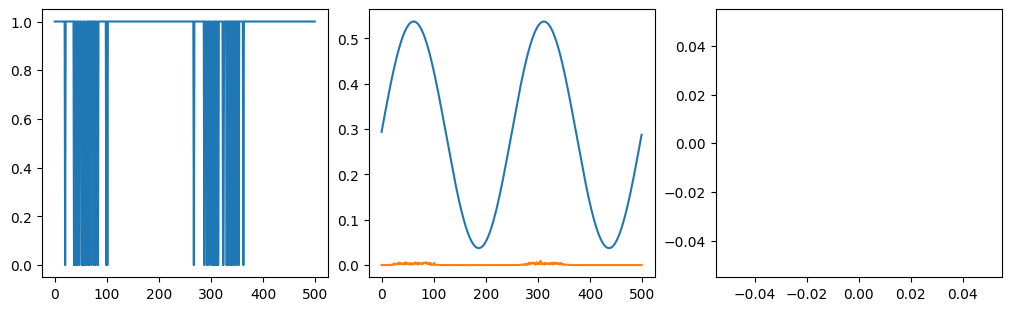

In [10]:
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (10, 3))
ax[0].plot(np.mean(np.stack(cover_lam1), axis = 0))

ax[1].plot(np.array(0.25 * (1.15 + sd[1:])))
ax[1].plot(jnp.array(qvals))

ax[2].plot(np.mean(np.stack(width_lam1), axis = 0))
plt.show()

In [11]:
# np.corrcoef([sd[1:], np.array(qvals)])

In [13]:
# np.corrcoef([sd[1:], np.array(usc1_width)])

In [47]:
def phi_resample(xval, xtest, rval_phi, n_samp, n_slice, rng):
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    key1, key2, key3 = random.split(rng, 3)
    local_weights = lweights(xval.squeeze(), 
                             xtest.squeeze()[None,], 0.1)[0]
    
    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    
    phi = phi_slice(key2, npc, n_slice)
    qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest, 0.1, 'tukey', 10, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_phi @ phi, local_weights, 'tukey')
    
    return samp_phi, dphi, qval

In [48]:
# phi_resample = jit(phi_resample, static_argnums = (2, 3, 4))

In [49]:
local_ens.shape

(0, 100)

In [51]:
nsamp = 1000
npc = 50
nproj = 25
state = pcax.fit(rval_fno, n_components = npc)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    
    rng, key1, key2 = random.split(rng, 3)
    
    local_ens, dphi, qval = phi_resample(xval, xtest[k], rval_phi, nsamp, nproj, key1)
    local_ens = pcax.recover(state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest_fno[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

In [54]:
# # weight = local_weights(xval2, xtest2, gamma).squeeze()

# nsamp = 2000
# npc = 50
# state = pcax.fit(rval_fno, n_components = npc)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

# width = []
# usc1_risk = []
# usc1_width = []
# rng = random.PRNGKey(0)
# for k in trange(xtest.shape[0], leave = False):
#     rng, key1, key2 = random.split(rng, 3)

#     qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'mahal', 10, rng = key1)
#     dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'mahal')

#     unif = random.uniform(key2, (nsamp, npc))
#     quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

#     local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
#     local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
#     local_phi = quants[local_quants].T

#     dphi = vphi_depth(local_phi, rval_phi, local_weights, 'mahal')

#     local_ens = pcax.recover(state, local_phi)
#     local_ens = local_ens[dphi > qval]

#     uval = jnp.max(local_ens, axis = 0)
#     lval = jnp.min(local_ens, axis = 0)
#     width.append(np.mean(uval - lval))

#     usc1_risk.append(risk(lval, uval, rtest_fno[k]))
#     usc1_width.append(jnp.median(uval - lval))

In [55]:
# # weight = local_weights(xval2, xtest2, gamma).squeeze()

# nsamp = 2000
# npc = 50
# p_slice = 100
# state = pcax.fit(rval_fno, n_components = npc)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

# width = []
# usc1_risk = []
# usc1_width = []
# rng = random.PRNGKey(0)
# for k in trange(xtest.shape[0], leave = False):
#     rng, key1, key2, key3 = random.split(rng, 4)

# #     _, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'norm', 10, rng = key1)
# #     dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'norm')

#     local_weights = lweights(xval[:,0], xtest[k:(k+1),0], 0.1)[0]

#     unif = random.uniform(key2, (nsamp, npc))
#     quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

#     local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
#     local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
#     local_phi = quants[local_quants].T
    
#     phi = phi_slice(key3, npc, p_slice)
#     qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest[k], 0.1, 'tukey', 5, rng = key1)
#     dphi = vphi_depth(local_phi @ phi, rval_phi @ phi, local_weights, 'tukey')

#     local_ens = pcax.recover(state, local_phi)
#     local_ens = local_ens[dphi > qval]

#     uval = jnp.max(local_ens, axis = 0)
#     lval = jnp.min(local_ens, axis = 0)
#     width.append(np.mean(uval - lval))

#     usc1_risk.append(risk(lval, uval, rtest[k]))
#     usc1_width.append(jnp.median(uval - lval))

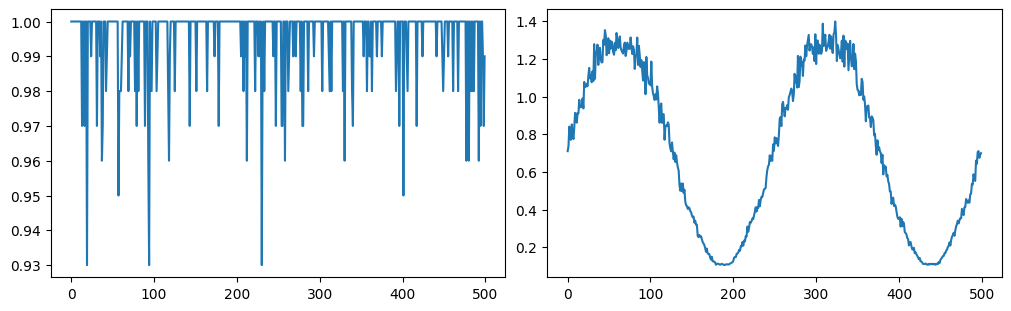

In [56]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()
# np.mean(usc1_risk)

In [73]:
np.mean(np.array(usc1_risk) >= 0.95)

0.994

In [74]:
usc_risk = np.array(np.array(usc1_risk) >= 0.95, dtype = np.int8)

In [77]:
np.corrcoef([sd[1:], usc_risk])

array([[ 1.        , -0.02588357],
       [-0.02588357,  1.        ]])

In [158]:
## coverage gap: shrinks with bandwidth lambda
n = 1000
d0 = np.random.uniform(0, 1, n)
d = d0.copy()
# d[d > np.quantile(d, 0.001)] = np.inf
w = np.exp(-1000*d)
w = w/(1 + np.sum(w))
np.sum(w * d0)/(1 + np.sum(w))

0.00030759216990301573

In [176]:
z = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5],[0.5, 2]]), (5000,))
phi = phi_slice(random.PRNGKey(0), 2, 50)
z_phi = z @ phi
d = vphi_depth(z_phi, z_phi, jnp.ones(1)/z.shape[0], 'tukey')

In [260]:
z = np.random.gamma(3, 9, (5000, 2))
phi = phi_slice(random.PRNGKey(0), 2, 50)
z_phi = z @ phi
d = vphi_depth(z_phi, z_phi, jnp.ones(1)/z.shape[0], 'tukey')

In [280]:
z1 = np.hstack([np.random.normal(0, 1, (5000, 1)),
                np.random.gamma(1, 4, (5000, 1))])

z1 = np.random.gamma(2, 9, (5000, 2))
z2 = (z1 - np.min(z1, axis = 0)[None,])/(np.max(z1, axis = 0)[None,] - np.min(z1, axis = 0)[None,])
phi = phi_slice(random.PRNGKey(0), 2, 50)
d1 = vphi_depth(z1 @ phi, z1 @ phi, jnp.ones(1)/z.shape[0], 'tukey')
d2 = vphi_depth(z2 @ phi, z2 @ phi, jnp.ones(1)/z.shape[0], 'tukey')

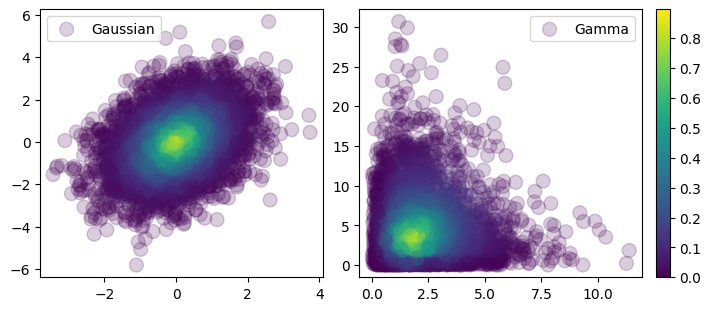

In [319]:
z1 = np.random.multivariate_normal(np.zeros(2), np.array([[1, 0.5],[0.5, 2]]), (5000,))

z2 = np.hstack([np.random.gamma(2, 1, (5000, 1)),
                np.random.gamma(1, 4, (5000, 1))])

phi = phi_slice(random.PRNGKey(0), 2, 50)
d1 = vphi_depth(z1 @ phi, z1 @ phi, jnp.ones(1)/z.shape[0], 'tukey')
d2 = vphi_depth(z2 @ phi, z2 @ phi, jnp.ones(1)/z.shape[0], 'tukey')

fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (7, 3))
im = ax[0].scatter(z1[:,0], z1[:,1], c = d1, s = 100, alpha = 0.2, label = 'Gaussian')
im = ax[1].scatter(z2[:,0], z2[:,1], c = d2, s = 100, alpha = 0.2, cmap = 'viridis', label = 'Gamma')

ax[0].legend()
ax[1].legend()
cbar = plt.colorbar(im, ax = ax[1])
cbar.solids.set(alpha=1)

# ax[0].axis('off')
# ax[1].axis('off')
plt.show()

In [239]:
# weight = local_weights(xval2, xtest2, gamma).squeeze()

state = pcax.fit(rval_fno, n_components = p_dim)
# rval_phi = pcax.transform(state, rval_fno)
# rtest_phi = pcax.transform(state, rtest_fno)

wave_shape = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)
wave_shape = [a.shape[1] for a in wave_shape]

rval_phi = jwt.wavedec(rval_fno, 'haar', mode='zero', level=2)[0]
rtest_phi = jwt.wavedec(rtest_fno, 'haar', mode='zero', level=2)[0]

nsamp = 2000
npc = p_dim

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    rng, key1, key2 = random.split(rng, 3)

    qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'mahal', 10, rng = key1)
    dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'mahal')

    unif = random.uniform(key2, (nsamp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dphi = vphi_depth(local_phi, rval_phi, local_weights, 'mahal')

#     local_ens = pcax.recover(state, local_phi)
    local_ens = [local_phi, 
                 0.01*random.normal(key2, (nsamp, wave_shape[1])), 
                 0.01*random.normal(key2, (nsamp, wave_shape[2]))]
    local_ens = jwt.waverec(local_ens, 'haar')
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

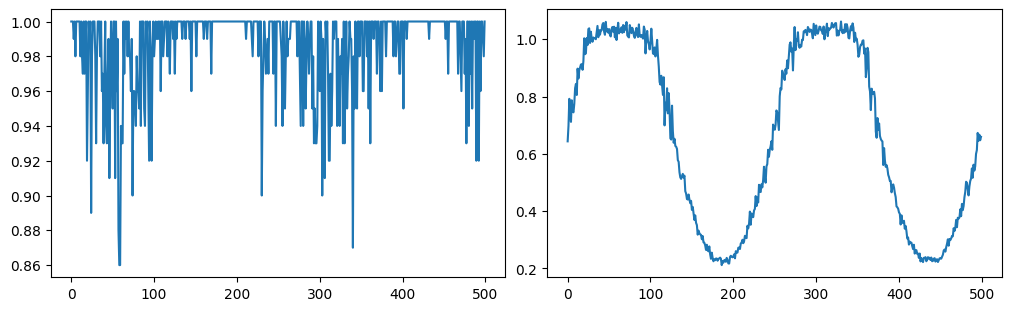

In [240]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()

In [241]:
np.mean(np.array(usc1_risk) >= 0.99)

0.606

In [263]:
# weight = local_weights(xval2, xtest2, gamma).squeeze()

nsamp = 2000
npc = 50
state = pcax.fit(rval_fno, n_components = npc)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

rval_fft = jnp.fft.fft(rval_fno)
rval_real = jnp.real(rval_fft)
rval_imag = jnp.imag(rval_fft)
rval_phi = jnp.hstack([rval_real, rval_imag])

rtest_fft = jnp.fft.fft(rtest_fno)
rtest_real = jnp.real(rtest_fft)
rtest_imag = jnp.imag(rtest_fft)
rtest_phi = jnp.hstack([rtest_real, rtest_imag])

width = []
usc1_risk = []
usc1_width = []
rng = random.PRNGKey(0)
for k in trange(xtest.shape[0], leave = False):
    rng, key1, key2 = random.split(rng, 3)

    qval, local_weights = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key1)
    dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')

    unif = random.uniform(key2, (nsamp, rval_phi.shape[1]))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    local_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dphi = vphi_depth(local_phi, rval_phi, local_weights, 'tukey')
    
    local_ens = jax.lax.complex(local_phi[:,:100], local_phi[:,100:])
    local_ens = jnp.real(jnp.fft.ifft(local_ens))
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    width.append(np.mean(uval - lval))

    usc1_risk.append(risk(lval, uval, rtest[k]))
    usc1_width.append(jnp.median(uval - lval))

  0%|          | 0/500 [00:00<?, ?it/s]

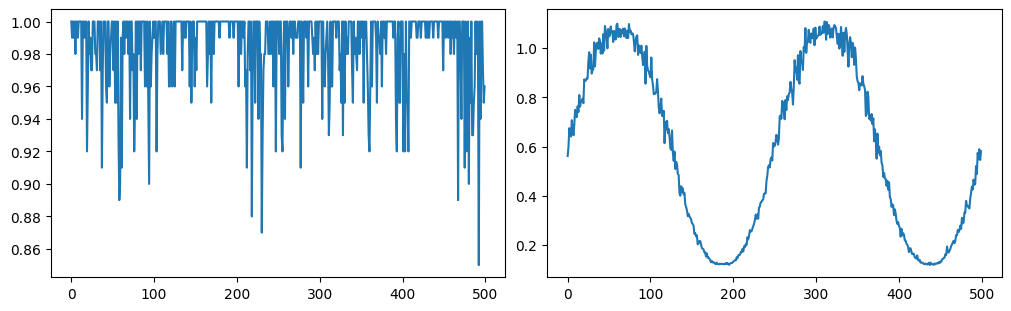

In [264]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(usc1_risk)
ax[1].plot(usc1_width)
plt.show()

In [266]:
np.mean(np.array(usc1_risk) >= 0.99)

0.566

In [ ]:
nproj = npc = 200
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

lsc1_risk, lsc1_width = [], []

rval = yval[:,0] - yval_fno
rtest = ytest[:,0] - ytest_fno
state = lsci.lsci_state(xval.reshape(n, -1), rval, npc)
pca_state = state[-1]

for i in trange(0, ytest.shape[0]):
    
    xtest_i = xtest[i].reshape(1, -1)
    rtest_i = rtest[i].reshape(1, -1)
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest_i, state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest_i))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))

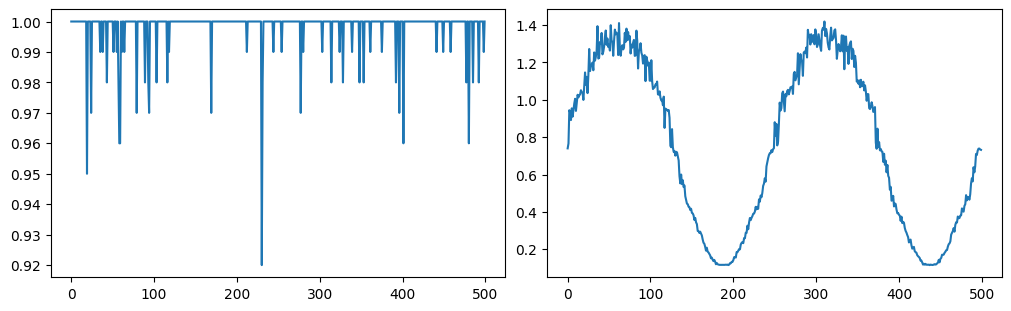

In [20]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10, 3))
ax[0].plot(lsc1_risk)
ax[1].plot(lsc1_width)
plt.show()

In [235]:
w1 = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'tukey', 10, rng = key4)[1]
w2 = lweights(xval[:,0], xtest[k:(k+1),0], 0.1)[0]

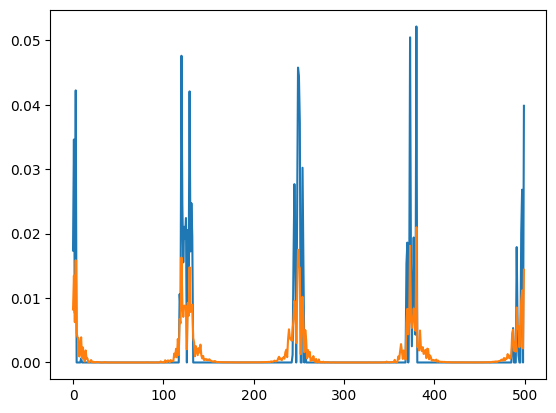

In [237]:
plt.plot(w2)
plt.plot(w1)

In [238]:
def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, lam, rng):
    
    xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
    dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
    local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))

#     local_weights = lweights(xval[:,0], xtest, 1/lam)[0]
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights, dval
phi_quantile = jit(phi_quantile, static_argnames='depth_fn')

In [242]:
cover = []

##### random basis
state = pcax.fit(rval_fno, n_components = p_dim)
rval_phi = pcax.transform(state, rval_fno)
rtest_phi = pcax.transform(state, rtest_fno)

k = 1
qval, local_weights, dval = phi_quantile(rval_phi, xval, xtest[k], 0.1, 'norm', 5, rng = key4)
dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'norm')
cover.append(dtest > qval)

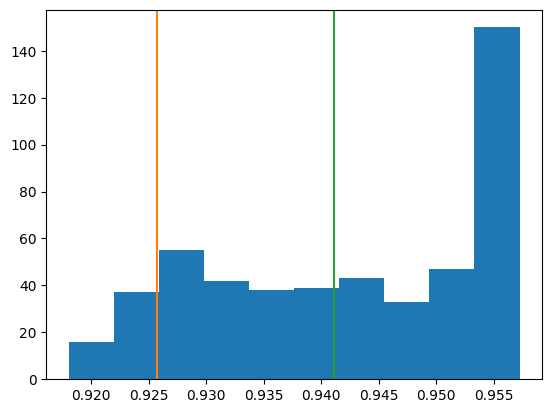

In [243]:
plt.hist(dval)
plt.axvline(qval, c = 'C1')
plt.axvline(dtest, c = 'C2')
plt.show()

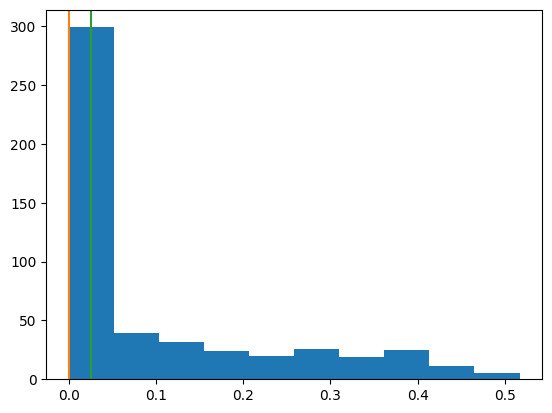

In [57]:
plt.hist(dval)
plt.axvline(qval, c = 'C1')
plt.axvline(dtest, c = 'C2')
plt.show()

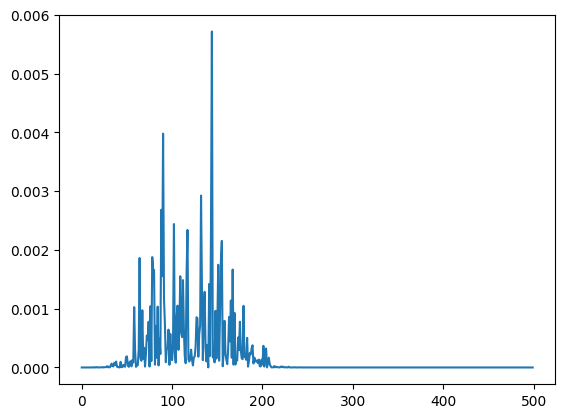

In [380]:
plt.plot(local_weights)

In [255]:
xval_fpca = jnp.stack([jnp.mean(xval, axis = (1, 2)), 
                       jnp.var(xval, axis = (1, 2))]).T
xtest_fpca = jnp.stack([jnp.mean(xtest, axis = (1, 2)), 
                        jnp.var(xtest, axis = (1, 2))]).T

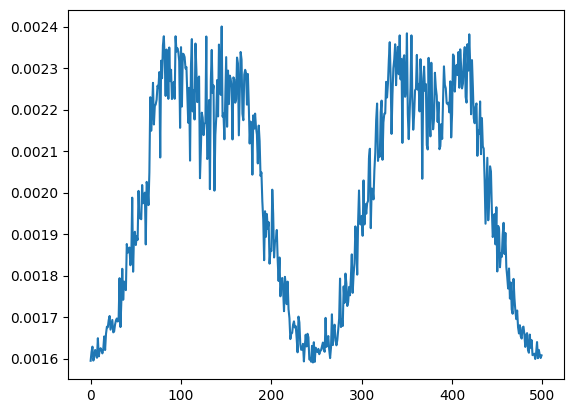

In [257]:
k = 100
qval, local_weights = phi_quantile(rval_phi, xval_fpca[:,None], xtest_fpca[:,None][k], 0.1, 'tukey', 1, rng = key4)
dtest = phi_depth(rtest_phi[k], rval_phi, local_weights, 'tukey')
plt.plot(local_weights)

In [ ]:
weight = local_weights(xval2, xtest2, gamma).squeeze()
unif = random.uniform(rng, (nsamp, npc))
quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, nval+1)

local_cdfs = lcdf(rval2, quants, weight)
local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
local_phi = quants[local_quants].T

dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0) * jnp.min(local_tukey_self(rval2, rval2, weight), axis = 0)
qval = jnp.quantile(dval, alpha)
dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

local_ens = pcax.recover(pca_state, local_phi)
local_ens = local_ens[dphi > qval]
return local_ens